In [1]:
import scipy.io
import numpy as np 
import pdb
import torch
#from common.data_normalization import *
#from common.pt_build_model import *
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random
from sys import argv
ho_suf='_ho0.999'
path='/Users/zsbjltwjj/Downloads/t42_hand/zs_sim_robot/trans_model_data/gazebo_ah_model/sim_cont_trajT_bs512_model512_BS64_loadT'+ho_suf
norm_path='/Users/zsbjltwjj/Downloads/t42_hand/zs_sim_robot/trans_model_data/gazebo_ah_normalization/normalization_arr_sim_cont_trajT_bs512_model512_BS64_loadT'+ho_suf+'_py2'
# argv lr heldout nntype seed dropout nodes epoch nm ne suffix(v1_, avi_v1_, ...)

(1036, 2)


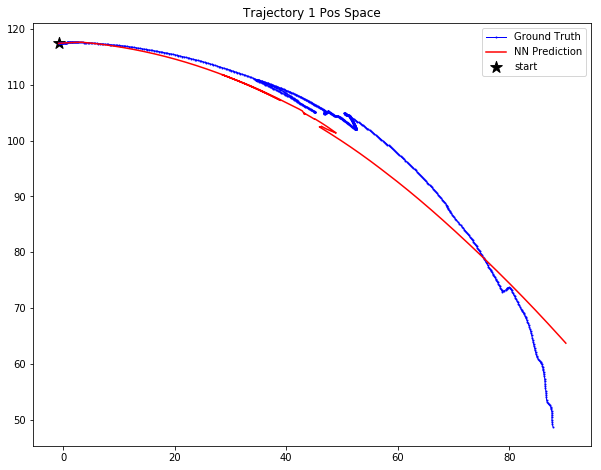

(1397, 2)


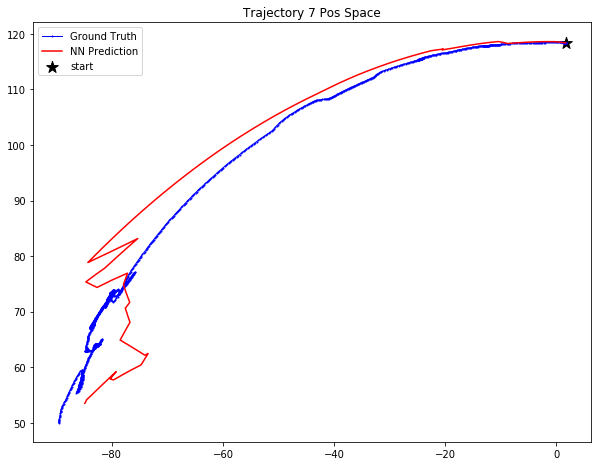

(1579, 2)


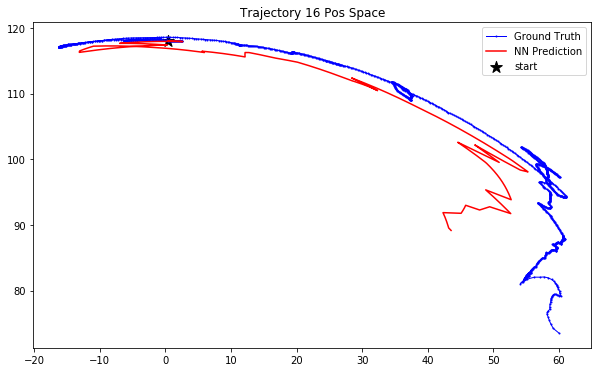

(3581, 2)


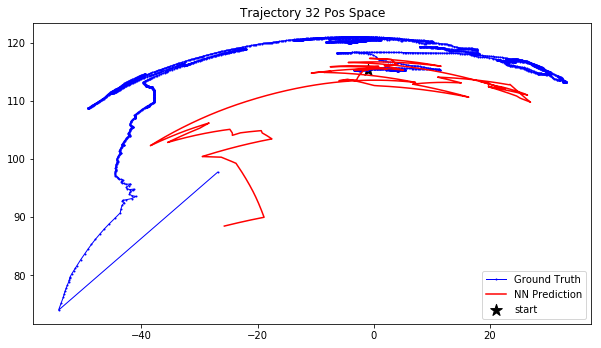

In [3]:
file_name='/Users/zsbjltwjj/Desktop/robotic_hand_simulator/sim_data_cont_v0_d4_m1_episodes.obj'
with open(file_name, 'rb') as filehandler:
    memory = pickle.load(filehandler,encoding='latin')
def normalize(data,x_std_arr,x_mean_arr):
    return (data - x_mean_arr[:data.shape[-1]]) / x_std_arr[:data.shape[-1]]
def denormalize(data,y_std_arr,y_mean_arr):
    return data * y_std_arr[:data.shape[-1]] + y_mean_arr[:data.shape[-1]]
def get_ground_truth(gd,gd_next):
    traj=[gd[0,:2]]
    for i in range(gd.shape[0]-1):
        if (gd_next[i,:]==gd[i+1,:]).all():
            traj.append(gd[i+1,:2])
        else:
            traj.append(gd_next[i,:2])
            traj.append(gd[i+1,:2])
    traj.append(gd_next[-1,:2])
    return np.array(traj)
def predict(init_state,ac,norm_name,model):
    with open(norm_name, 'rb') as pickle_file:
        x_norm_arr, y_norm_arr = pickle.load(pickle_file)
        x_mean_arr, x_std_arr = x_norm_arr[0], x_norm_arr[1]
        y_mean_arr, y_std_arr = y_norm_arr[0], y_norm_arr[1]
    next_state_ls=[init_state[:2]]
    for i in range(ac.shape[0]):
        sa=np.concatenate([init_state,ac[i,:]])
        inpt = normalize(sa,x_std_arr,x_mean_arr)
        inpt = torch.tensor(inpt, dtype=torch.float)
        state_delta = model(inpt)    
        state_delta = state_delta.detach().numpy()
        state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
        next_state= (sa[:4] + state_delta)
        next_state_ls.append(next_state[:2])
        init_state=next_state
    return np.array(next_state_ls)
i=1
for idx in [0,6,15,31]:
    gd=memory[idx][:,:4]
    gd_next=memory[idx][:,-4:]
    ac=memory[idx][:,4:6]
    gd_truth=get_ground_truth(gd,gd_next)

    model_name = path
    norm_name = norm_path
    with open(model_name, 'rb') as pickle_file:
        model = torch.load(pickle_file, map_location='cpu')

    pred_states=predict(gd[0,:],ac,norm_name,model)
    print(pred_states.shape)
    fig = plt.figure()
    plt.scatter(gd_truth[0, 0], gd_truth[0, 1], s=150, c='k', marker="*",label='start')
    plt.plot(gd_truth[:, 0], gd_truth[:, 1], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
    plt.plot(pred_states[:, 0], pred_states[:, 1], color='red', label='NN Prediction')
    plt.axis('scaled')
    
    plt.title('Trajectory '+str(idx+1)+ ' Pos Space')
    plt.legend()
    fig_loc='/Users/zsbjltwjj/Downloads/t42_hand/zs_sim_robot/trans_model_data/gazebo_ah_pred/traj_'+str(i)+ho_suf+'_pos.png'
    fig.set_size_inches(10, 10)
    fig.savefig(fig_loc)
    plt.show()
    i+=1

In [4]:
import scipy.io
import numpy as np 
import pdb
import torch
from common.data_normalization import *
from common.pt_build_model import *
import matplotlib.pyplot as plt
import glob,pickle,os,copy,sys,random
import sys
from mjo_exp.hyperparameters import *


Rolling out 10 test trajectories.


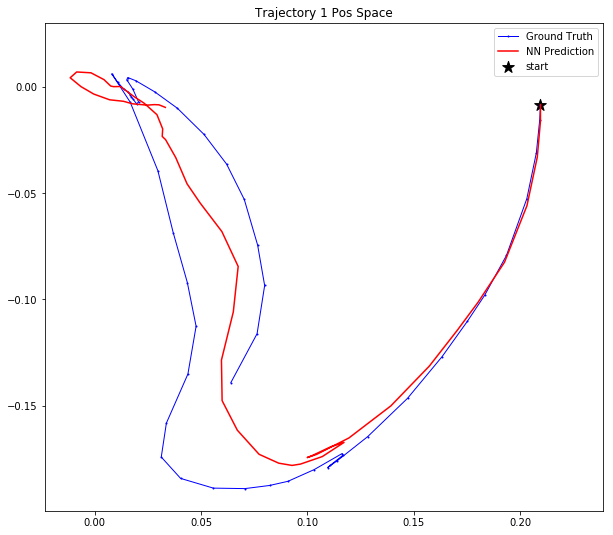

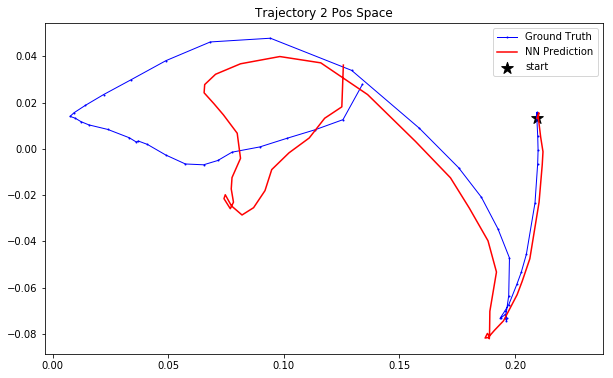

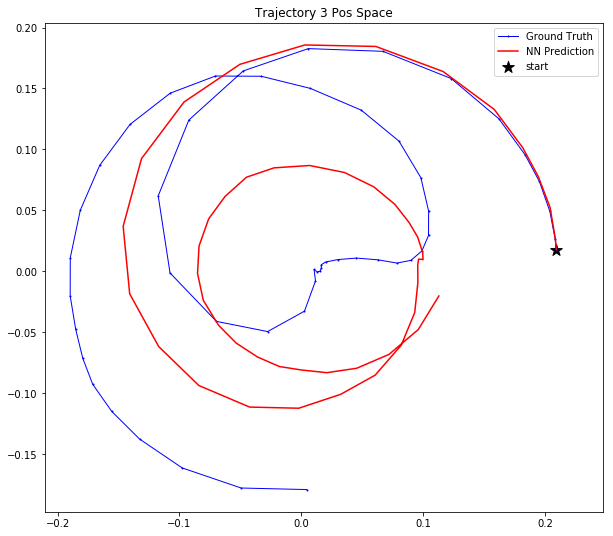

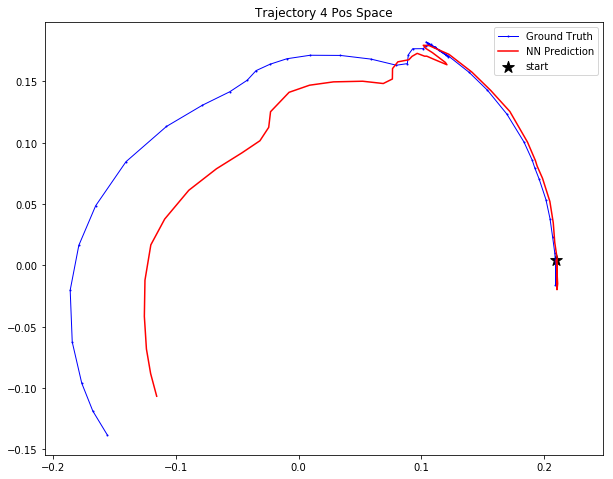

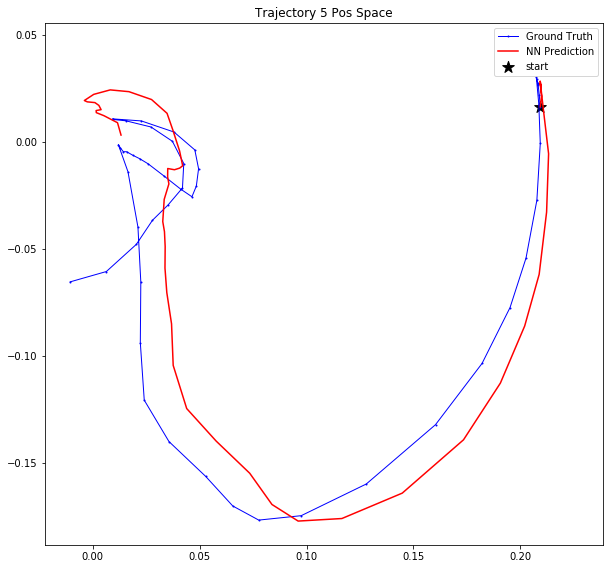

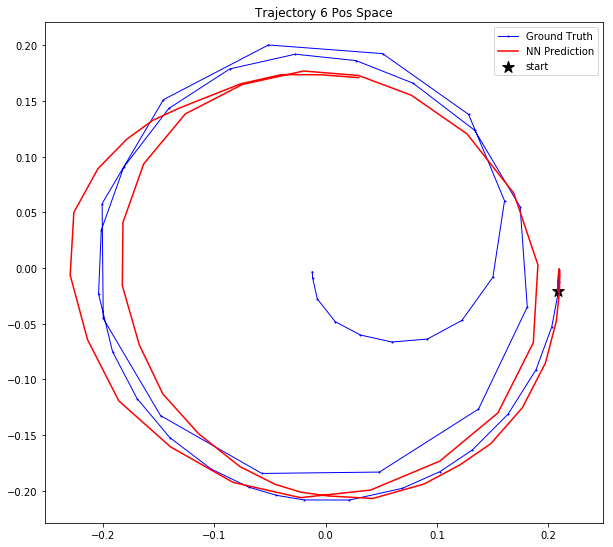

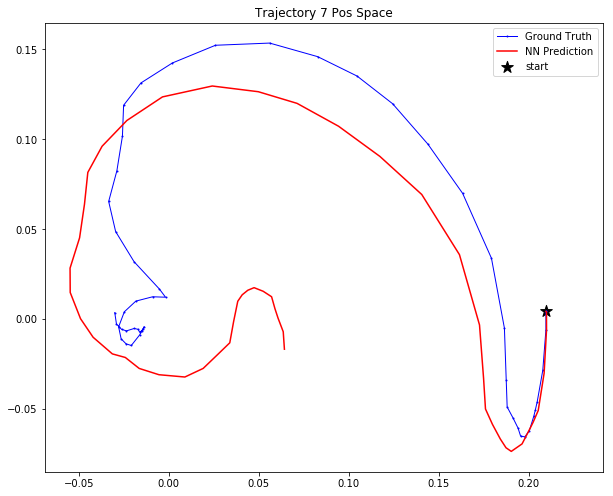

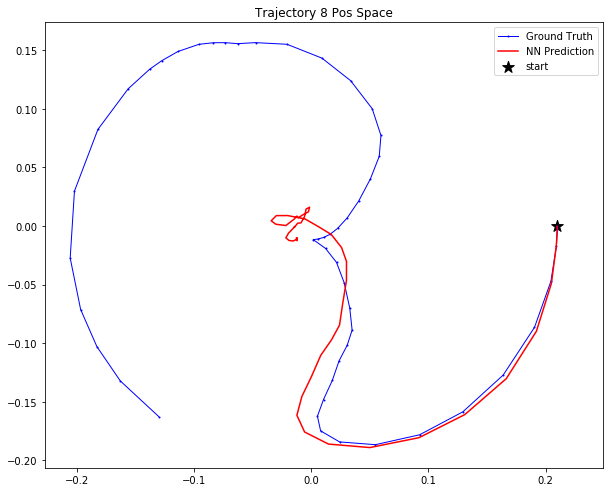

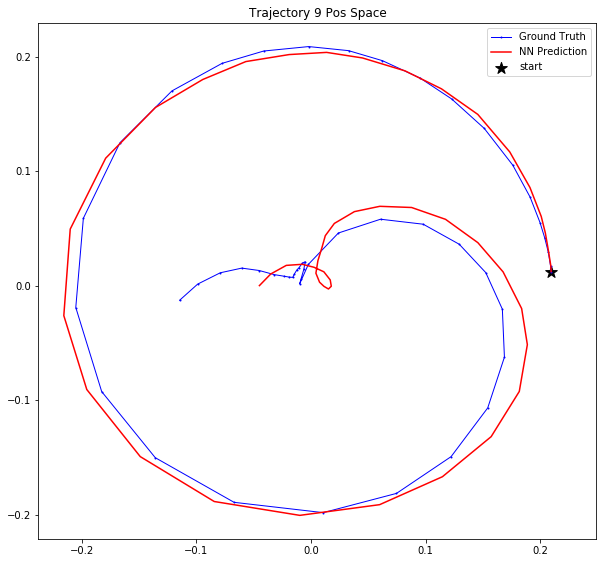

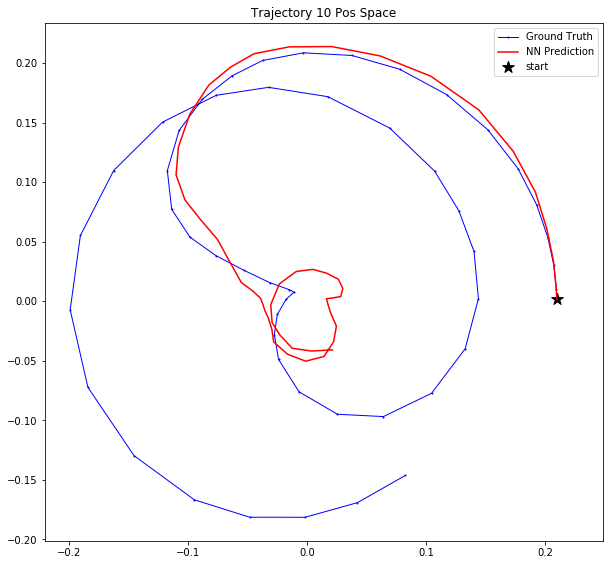

In [11]:
#argv num_test env_name lr nodes model_ep model_name_suffix(_v1, ...) data_file_suffix seed
seed=0
num_test=10
env_name='Reacher-v2'
lr='0.0001'
nodes='512'
model_ep=100
data_file_suffix='train'
xy_plot=1
model_name_suffix=''
ho_suf='_ho0.999'

dropout_rate = .0
epoch_save_interval=5
retrain=False
batch_size = 200
wd = .001
nn_type = '1'
both_nn_type='1'
every_plot=1
cuda = torch.cuda.is_available()
dtype = torch.float

num_test=int(num_test)
lr=float(lr)
nodes=int(nodes)
model_ep=int(model_ep)
seed=int(seed)
xy_plot=int(xy_plot)

train_ds_path='/Users/zsbjltwjj/Desktop/mjo_eps_data/'+env_name+'_'+data_file_suffix+'_episode_data.pkl'
with open(train_ds_path, 'rb') as pickle_file:
    processed_eps_ls,rwd_ls,done_ls,goal_ls = pickle.load(pickle_file)

if env_name=='Reacher-v2':
    if use_partial_state:
        state_dim=8
        x_loc=state_dim-2
        y_loc=state_dim-1
    else:
        state_dim=11
        x_loc=0
        y_loc=1
    action_dim=2

task_ofs = state_dim + action_dim
if env_name=='Reacher-v2':
    test_ds_ls = [torch.tensor(data, dtype=dtype) for data in processed_eps_ls[:num_test]]
real_test_actions=[eps[:,state_dim:task_ofs].clone().detach() for eps in test_ds_ls]
test_eps_len=[eps.shape[0] for eps in test_ds_ls]
print("Rolling out " + str(len(test_ds_ls)) + " test trajectories.")

cuda = False
dtype = torch.float

save_path = './trans_model_data'+model_name_suffix+'/'
model_path=save_path+env_name+'_model/'
error_path = save_path+env_name+'_error/'
norm_path = save_path+env_name+'_normalization/'
pred_path = save_path+env_name+'_pred/'
if not os.path.exists(pred_path):
    os.makedirs(pred_path)

model_save_path = model_path + env_name + '_model_lr' + str(lr)+ '_nodes' + str(nodes) + '_seed'+str(seed)+ho_suf
pred_fig_path = pred_path + 'traj_lr' + str(lr)+ '_nodes' + str(nodes) + '_seed'+str(seed)
if model_ep!=0:
    model_save_path += '_epochs_'+str(model_ep)
    pred_fig_path += '_epochs_'+str(model_ep)

with open(model_save_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
if cuda: 
    model = model.to('cuda')
    model.norm = tuple(n.cuda() for n in model.norm)

torch.manual_seed(seed)
model.eval()
for i in range(len(test_ds_ls)):
    prev_states = test_ds_ls[i][:,:state_dim]
    real_actions = real_test_actions[i]
    gt_states_for_plot = torch.cat((prev_states[:1,:],test_ds_ls[i][:,task_ofs:]),dim=0)
    if cuda:
        prev_states = prev_states.cuda()
        gt_states_for_plot = gt_states_for_plot.cuda()
        model = model.to('cuda')
        model.norm = tuple([n.cuda() for n in model.norm])
    with torch.no_grad():
        pred_states = model.run_traj(prev_states,real_actions)

    fig = plt.figure()
    if env_name=='Reacher-v2':
        if not use_partial_state:
            gt_states_for_plot=gt_states_for_plot[:,8:10]+gt_states_for_plot[:,4:6]
            pred_states=pred_states[:,8:10]+pred_states[:,4:6]


    plt.scatter(gt_states_for_plot[0, x_loc], gt_states_for_plot[0, y_loc], s=150, c='k', marker="*",label='start')
    plt.plot(gt_states_for_plot[:, x_loc], gt_states_for_plot[:, y_loc], color='blue', label='Ground Truth', marker='.', markersize=2, linewidth=1)
    plt.plot(pred_states[:, x_loc], pred_states[:, y_loc], color='red', label='NN Prediction')
    plt.axis('scaled')
    fig_loc=pred_fig_path +'_traj_'+str(i+1)+ho_suf+'_pos.png'
    plt.title('Trajectory '+str(i+1)+ ' Pos Space')
    plt.legend()
    fig.set_size_inches(10, 10)
    fig.savefig(fig_loc)